# Ficheux-like gate between a transmon and a fluxonium: effect on a spectator

In this notebook we study the effect on the gate on a spectator qubit. 

In [1]:
import numpy as np
import time
import qutip as qtp
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pysqkit
from pysqkit.util.metrics import average_process_fidelity, \
    average_gate_fidelity
from pysqkit.util.phys import temperature_to_thermalenergy
from pysqkit.util.quantum import generalized_rabi_frequency
import pysqkit.util.transformations as trf
from pysqkit.util.hsbasis import weyl_by_index
from typing import List, Dict, Callable
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
import util_cphase as util

from IPython.display import display, Latex

The gate is based on the following driven Hamiltonian of a fluxonium and a transmon capacitively coupled

$$H = H^{(0)}_T + H^{(0)}_F + V + H_{drive},$$

$$H^{(0)}_T =  \hbar \omega_T \hat{b}^{\dagger}\hat{b} + \hbar \frac{\delta_T}{2} \hat{b}^{\dagger} \hat{b}^{\dagger}\hat{b} \hat{b},$$

$$H^{(0)}_F = 4 E_{C,F} \cdot \hat{q}^2_F + \frac{1}{2}E_{L,F}\cdot\hat{\varphi}^2_F - E_{J,F}\cos\left(\hat{\varphi}_F - \phi_{ext,F}\right),$$

$$V = J_C \cdot \hat{q}_T \cdot \hat{q}_F,$$

$$\frac{H_{drive}}{h} = \left( \varepsilon_T \hat{q}_T + \varepsilon_F \hat{q}_F \right) \cos(2\pi f_d t).$$

The (approximate) charge operator for the transmon in terms of annihilation and creation operators reads

$$
\hat{q}_T = i \biggl( \frac{E_J}{32 |\delta_T |} \biggr)^{1/4} (b^{\dagger} - b),
$$
where 
$$
E_J = \hbar \biggl(\frac{\omega_T - \delta_T}{8 | \delta_T |} \biggr)^2.
$$

In the following we introduce relaxation due to dielectric loss and pure dephasing on each qubit as error channels. 

# Introducing the qubits and the coupled system

In [35]:
parameters_set = {}

parameters_set["0"] = {"max_freq_t": 4.5, "anharm_t": -0.3, "diel_loss_tan_t": 0.75*1e-6*20,
                     "dephasing_times_t": {'1': 2*np.pi*50*1e3, '2': 2*np.pi*30*1e3}, 
                     "charge_energy_f": .973, "induct_energy_f": .457, "joseph_energy_f": 8.0, 
                     "diel_loss_tan_f": 7.1*1e-6, "dephasing_times_f": {'1': 2*np.pi*200*1e3, '2':2*np.pi*20*1e3, 
                                                                        '3': 2*np.pi*20*1e3, '4': 2*np.pi*5*1e3},
                      "jc": 0.07}

parameters_set["spec_0"] = {"max_freq_t": 5.0, "anharm_t": -0.3, "diel_loss_tan_t": 0.75*1e-6*20,
                     "dephasing_times_t": {'1': 2*np.pi*50*1e3, '2': 2*np.pi*30*1e3}, 
                     "charge_energy_f": .973, "induct_energy_f": .457, "joseph_energy_f": 8.0, 
                     "diel_loss_tan_f": 7.1*1e-6, "dephasing_times_f": {'1': 2*np.pi*200*1e3, '2':2*np.pi*20*1e3, 
                                                                        '3': 2*np.pi*20*1e3, '4': 2*np.pi*5*1e3},
                      "jc": 0.07}

parameters_set["1"] = {"max_freq_t": 4.03, "anharm_t": -0.3, "diel_loss_tan_t": 0.75*1e-6*20,
                     "dephasing_times_t": {'1': 2*np.pi*50*1e3, '2': 2*np.pi*30*1e3}, 
                     "charge_energy_f": 1.3, "induct_energy_f": .8, "joseph_energy_f": 6.0, 
                     "diel_loss_tan_f": 7.1*1e-6, "dephasing_times_f": {'1': 2*np.pi*200*1e3, '2':2*np.pi*20*1e3, 
                                                                        '3': 2*np.pi*20*1e3, '4': 2*np.pi*5*1e3},
                      "jc": 0.02}

parameters_set["spec_1"] = {"max_freq_t": 4.8, "anharm_t": -0.3, "diel_loss_tan_t": 0.75*1e-6*20,
                     "dephasing_times_t": {'1': 2*np.pi*50*1e3, '2': 2*np.pi*30*1e3}, 
                     "charge_energy_f": 1.3, "induct_energy_f": .8, "joseph_energy_f": 6.0, 
                     "diel_loss_tan_f": 7.1*1e-6, "dephasing_times_f": {'1': 2*np.pi*200*1e3, '2':2*np.pi*20*1e3, 
                                                                        '3': 2*np.pi*20*1e3, '4': 2*np.pi*5*1e3},
                      "jc": 0.02}

In [54]:
temperature = 0.020 # K
thermal_energy = temperature_to_thermalenergy(temperature) # kb T/h in GHz
d_comp = 4

p_set = "1"


#Transmon
levels_t = 3
transm = pysqkit.qubits.SimpleTransmon(
    label='T', 
    max_freq=parameters_set[p_set]["max_freq_t"], 
    anharm=parameters_set[p_set]["anharm_t"],
    diel_loss_tan=parameters_set[p_set]["diel_loss_tan_t"], #set to zero to check d_1 L1 = d_2 L2
    env_thermal_energy=thermal_energy,    
    dim_hilbert=levels_t,
    dephasing_times=parameters_set[p_set]["dephasing_times_t"]
)

transm_spectator = pysqkit.qubits.SimpleTransmon(
    label='SPECTATOR', 
    max_freq=parameters_set["spec_" + p_set]["max_freq_t"], 
    anharm=parameters_set["spec_" + p_set][ "anharm_t"],
    diel_loss_tan=parameters_set["spec_" + p_set]["diel_loss_tan_t"], #set to zero to check d_1 L1 = d_2 L2
    env_thermal_energy=thermal_energy,    
    dim_hilbert=levels_t,
    dephasing_times=parameters_set["spec_" + p_set]["dephasing_times_t"]
)

#Fluxonium
levels_f = 5
flx = pysqkit.qubits.Fluxonium(
    label='F', 
    charge_energy=parameters_set[p_set]["charge_energy_f"], 
    induct_energy=parameters_set[p_set]["induct_energy_f"], 
    joseph_energy=parameters_set[p_set]["joseph_energy_f"], #8.0, 
    diel_loss_tan=parameters_set[p_set]["diel_loss_tan_f"], #set to zero to check d_1 L1 = d_2 L2
    env_thermal_energy=thermal_energy,
    dephasing_times= parameters_set[p_set]["dephasing_times_f"] #ns/2*np.pi 
)
flx.diagonalize_basis(levels_f)

# We also add a drive on the fluxonium
flx.add_drive(
    pysqkit.drives.microwave_drive,
    label='cz_drive_f',
    pulse=pysqkit.drives.pulses.cos_modulation,
    pulse_shape=pysqkit.drives.pulse_shapes.gaussian_top
)

d_leak = levels_t*levels_f - d_comp

jc = parameters_set[p_set]["jc"]
coupled_sys = transm.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
coupled_sys_spectator = transm_spectator.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
bare_system = transm.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=0.0)
bare_system_spectator = transm_spectator.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=0.0)

In [55]:
coupled_sys.state('04')[0] - coupled_sys.state('03')[0]

4.000767148055155

The basis principle behind the gate is illustrated in the following figure

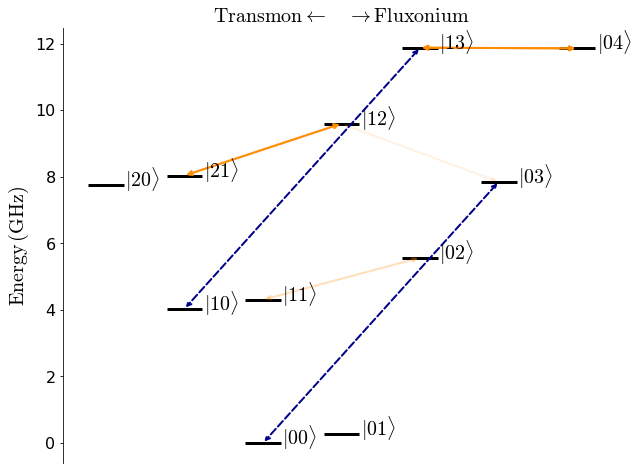

In [56]:
level_list = ['00', '01', '10', '11', '02', '20', '12','21', '03', '13', '04']

util.energy_levels_diagram(bare_system, level_list)

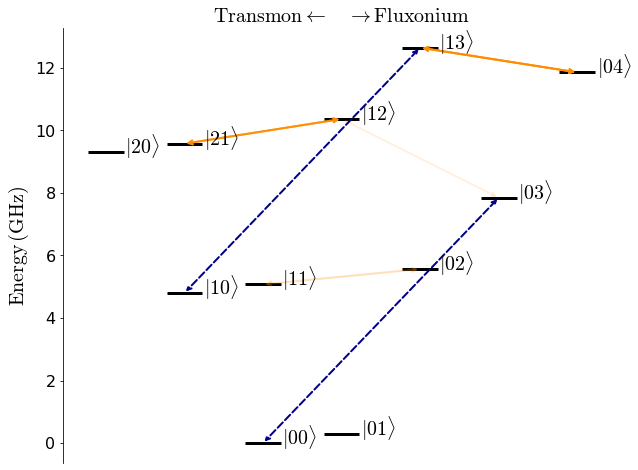

In [57]:
util.energy_levels_diagram(bare_system_spectator, level_list)

The figure shows the energy of the bare levels. The orange arrows indicate the non-zero matrix elements between the (bare) levels provided by the capacitive coupling $V$: the more shaded the arrow the weaker the coupling. The idea is to design the system so that the $| 1 3 \rangle$-$|0 4 \rangle$ is close to resonance so that the levels get sufficiently hybridized. A CZ gate can then be realized by driving the $|0 \rangle$-$|3 \rangle$ transition of the fluxonium, which induces transitions depicted by the blue, dashed arrow in the figure. The scheme is inspired by the one between two fluxonia described in Ficheux et al. Phys. Rev. X 11, 021026 (2021), where the $|2 1  \rangle$ and $|12 \rangle$ levels are hybridized and the transition $| 1 \rangle$-$|2 \rangle$ of one of the two fluxonia is driven.

We look at the following quantities : 

$$\zeta_{ZZ} = E_{00} + E_{11} - E_{01} - E_{10}$$
$$\Delta = \left( E_{13} - E_{10} \right) -  \left( E_{03} - E_{00} \right)$$

The $\Delta$ is similar at the one in Ficheux but looking at the 0-3 transition of the Fluxonium.

For the given parameters we have

In [58]:
display(Latex(r'$\xi_{{ZZ}}/h = {:.3f} \, \mathrm{{MHz}}$'.format(1e3*util.zz(coupled_sys))))
display(Latex(r'$\Delta/h = {:.3f} \, \mathrm{{MHz}}$'.format(1e3*util.delta(coupled_sys))))
display(Latex(r'$\xi_{{ZZ, spec}}/h = {:.3f} \, \mathrm{{MHz}}$'.format(1e3*util.zz(coupled_sys_spectator))))
display(Latex(r'$\Delta_{{spec}}/h = {:.3f} \, \mathrm{{MHz}}$'.format(1e3*util.delta(coupled_sys_spectator))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Matching the parameters
For this case we look at the 10-13 and 00-03 transitions so we process the corresponding Rabi frequencies :

$$\Omega_{10-13}  = \left| \epsilon_T \langle 10 | \hat{n}_T | 13 \rangle + \epsilon_F \langle 10 | \hat{n}_F | 13 \rangle \right|$$
$$\Omega_{00-03}  = \left| \epsilon_T \langle 00 | \hat{n}_T | 03 \rangle + \epsilon_F \langle 00 | \hat{n}_F | 03 \rangle \right|$$

And then :
$$r = \dfrac{\Omega_{10-13}}{\Omega_{00-03}} \text{  and  } \dfrac{\delta}{\Delta} = \dfrac{r^2 - \sqrt{(r^2-1)^2 + r^2 }} {r^2 - 1}$$ 

With these conventions taken in the paper :
$$\Delta = f_{10-13} - f_{00-03}$$
$$\delta = f_{10-13} - f_d$$

These conventions are taken in orde to have : $\Omega = \sqrt{\Omega_{10-13}^2  + \delta^2} = \sqrt{\Omega_{00-03}^2  + (\delta - \Delta)^2}$

The $\Delta$ is fixed by the parameters of the qubits, we now need to settle the values for the drive parameters.

First we need to fix the $\varepsilon$.

We take the condition of the paper :
$$\Omega = \Delta$$

However, one equation for two parameters is not enough. We assume that the fluxonium is driven much more than the transmon (as we are mainly looking at the 0-3 transtion of F) and, in general, we could take the drive on the transmon to be a fixed fraction of the one on the fluxonium. In what follows we simply set the drive on the transmon to be zero. Now we have enough constraints to find values for every parameters.


With this $\delta$, we have $\Omega = \Delta$ and a CZ gate is achieved with zero leakage in time exactly $t_{drive} = 1/\Delta$.

In order to setup the optimization define the following function that respects the scipy.optimize.minimize syntax. The vector of variable x0 in this case has length 2: the first entry is a reference drive strength, while the second the drive frequency. The drive parameters for each qubit are defined by providing the ratio between the qubit drive strength and the reference drive strength. This can be used to take into account potential classical crosstalk.

In [59]:
def func_to_minimize(
    x0: np.ndarray,
    levels_first_transition: List['str'],
    levels_second_transition: List['str'],
    system: pysqkit.systems.system.QubitSystem,
    eps_ratio_dict: Dict    
) -> float:
    
    """
    Function to minimize in order to match the parameters to 
    implement a CZ gate up to single-qubit rotations in the Ficheux scheme. 
    It returns the modulus of [rabi_second_transition - rabi_first_transition, 
    delta_gate - rabi_first_transition]/delta_gate
    x0 : np.ndarray([eps_reference, drive_freq]) represents the parameters to be 
         minimized.
    levels_first_transition : List with the labels of the first transition whose
       generalized Rabi frequency has to be matched
    levels_second_transition : List with the labels of the second transition whose
                               generalized Rabi frequency has to be matched
    system: coupled system we are analyzing
    eps_ratio_dict: dictionary whose keys are system.labels. The entries correspond
                    to the ratios between the corresponding qubit drive and the 
                    reference drive.     
    
    """
    
    qubit_labels = system.labels
    eps = {}
    for qubit in qubit_labels:
        eps[qubit] = x0[0]*eps_ratio_dict[qubit]
    rabi_first_transition = generalized_rabi_frequency(levels_first_transition, eps, x0[1], system)
    rabi_second_transition = generalized_rabi_frequency(levels_second_transition, eps, x0[1], system)
    delta_gate = util.delta(system)
    y = np.sqrt( (rabi_first_transition - rabi_second_transition)**2 + \
                (rabi_first_transition - delta_gate)**2)
    return np.abs(y/delta_gate)

In [61]:
# x0 = np.array([0.03, 7.15]) #initial guess
x0 = np.array([0.017, 7.85]) 
eps_ratios = {'T': 0.0, 'F':1.0}
args_to_pass = (['00', '03'], ['10', '13'], coupled_sys, eps_ratios) 

start = time.time()

minimization_result = minimize(func_to_minimize, x0, args=args_to_pass)

end = time.time()

display(Latex(r'$\mathrm{{Minimization \, time}} = {:.3f} \, s$'.format(end - start)))

<IPython.core.display.Latex object>

In [62]:
display(Latex(r'$y_{{\mathrm{{min}}}} = {:.2e}$'.format(minimization_result['fun'])))
display(Latex(r'$\epsilon_{{\mathrm{{d, opt}}}} = {:.7f}$'.format(minimization_result['x'][0])))
display(Latex(r'$f_{{\mathrm{{d,opt}}}} = {:.5f} \, \mathrm{{GHz}}$'.format(minimization_result['x'][1])))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [63]:
eps_drive = minimization_result['x'][0]
freq_drive = minimization_result['x'][1]
rabi_period = 1/util.delta(coupled_sys)
t_rise = 0*15.0 # [ns]
t_tot = rabi_period   # 60 [ns]
pts_per_drive_period = 5
print("Total gate time = {}".format(t_tot))

nb_points = int(t_tot*freq_drive*pts_per_drive_period)
tlist = np.linspace(0, t_tot, nb_points)

coupled_sys['F'].drives['cz_drive_f'].set_params(phase=0, time=tlist, rise_time=t_rise, 
                                                 amp=eps_drive, freq=freq_drive)
coupled_sys_spectator['F'].drives['cz_drive_f'].set_params(phase=0, time=tlist, rise_time=t_rise, pulse_time=t_tot, 
                                                 amp=eps_drive, freq=freq_drive)

Total gate time = 117.23740157512087


We introduce the TomoEnv object. We also refine the absolute and relative tolerance of the qutip solver 

In [64]:
simu_opt = qtp.solver.Options()
simu_opt.atol = 1e-12
simu_opt.rtol = 1e-10
env_syst = pysqkit.tomography.TomoEnv(system=coupled_sys, time=2*np.pi*tlist, options=simu_opt)
env_syst_spectator = pysqkit.tomography.TomoEnv(system=coupled_sys_spectator, time=2*np.pi*tlist, options=simu_opt)

The TomoEnv class can now return the superoperator representation of the quantum operation in an arbitrary Hilbert-Schmidt basis for a $d$-dimensional subspace, as long as this is a basis of diagonalizable operators. For instance the basis $|n \rangle \langle m|$, $n, m= 0, \dots, d-1$ is not a diagonalizable basis and thus the method cannot be used. 

In what follows we are interested in obtaining a superoperator representation of a quantum operation in the computational subspace that we here define

In [65]:
state_labels = ['00', '01', '10', '11']
comp_states = []
for label in state_labels:
    comp_states.append(coupled_sys.state(label)[1])

We remark that the specification of the subspace is left to the user and it has arbitrary dimension. The user must check that the given kets are indeed orthogonal. 

In what follows we will use the Weyl basis for qudits ($d>2$) as Hilbert-Schmidt basis. These are defined via the standard definition of $Z$ and $X$ operators for qudits (see Howard et al Nature volume 510, pages351–355 (2014)):

$$
Z | j \rangle= \omega^j | j \rangle,
$$
$$
X | j \rangle = | j + 1 \mod d \rangle,
$$
where $\omega = \exp \bigl[ \frac{2 \pi i}{d} \bigr ]$.

The (normalized) Weyl operators for qudits are defined as

$$
D(\boldsymbol{\xi})=D \bigl( \boldsymbol{\xi} = \begin{bmatrix}\xi_x & \xi_z 
\end{bmatrix}^T \bigr) = \frac{1}{\sqrt{d}} \omega^{- \frac{d+1}{2} \xi_x \xi_z} X^{\xi_x} Z^{\xi_z}, \quad \xi_x, \xi_z \in \mathbb{Z}_d = \{0, 1, \dots, d-1 \}.
$$
The Weyl operators form an orthonormal basis for the Hilbert space of (bounded) $d \times d$ matrices with Hilbert-Schmidt inner product

$$
\langle A, B \rangle = \mathrm{Tr}(A^{\dagger} B).
$$
In fact
$$
\langle D(\boldsymbol{\xi}), D(\boldsymbol{\xi}') \rangle = \delta_{\boldsymbol{\xi}, \boldsymbol{\xi}'}.
 $$

In order to use this basis to write our superoperator we simply need a function that orders them. Thus, this function should take as argument an index $i$ associated with the Weyl operator as well as the qudit dimension $d$ ($i < d^2$). The same is valid for any orthonormal Hilbert-Schmidt basis we wish to define, as long as it is a basis of diagonalizable matrices. 


We can easily obtain the superoperator in the Weyl basis. Notice that this gives information only within the defined computational subspace and not on the leakage subspace. Thus the following superoperator is complete knowledge of the states within the computational subspaces only if the leakage is zero. However, the following superoperator is the one needed to compute process fidelities as described in Eq. 8 of Wood-Gambetta Phys. Rev. A 97, 032306 (2018). The method to_super in the TomoEnv class is parallelized and we can specify the number of processes. 

In [66]:
n_process = 4

start = time.time()
#sup_op = env_syst.to_super(comp_states, weyl_by_index, n_process)
sup_op_spectator = env_syst_spectator.to_super(comp_states, weyl_by_index, n_process)
end = time.time()
print("Computational time = " + str(end - start) + ' s')

Computational time = 143.94216227531433 s


Notice how the superoperator can be obtained for any system and its operations are completely system agnostic.

We now use the previous superoperator to compute the process fidelity and average gate fidelity with respect to a $\mathrm{CZ}$ gate. First of all, we need to obtain the single-qubit gate corrections. This can be done directly from the superoperator via the following function.

In [67]:
#sq_corr = util.single_qubit_corrections(sup_op, weyl_by_index)
sq_corr_spectator = util.single_qubit_corrections(sup_op_spectator, weyl_by_index)
#sq_corr_sup = trf.kraus_to_super(sq_corr, weyl_by_index)
sq_corr_spectator_sup = trf.kraus_to_super(sq_corr_spectator, weyl_by_index)
#total_sup_op = sq_corr_sup.dot(sup_op)
total_sup_op_spectator = sq_corr_spectator_sup.dot(sup_op_spectator)

We now compute the process fidelity. In order to do this we first need to obtain the superoperator representation of the $\mathrm{CZ}$ in the Weyl basis, while in the case of the spectator this should lead to the identity. This can be done via the function qutip.util.transformations.kraus_to_super

In [68]:
ide = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
cz = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, -1]])
cz_super = trf.kraus_to_super(cz, weyl_by_index)
ide_super = trf.kraus_to_super(ide, weyl_by_index)

We can now compute the process fidelity

In [69]:
# f_pro = average_process_fidelity(cz_super, total_sup_op)
# display(Latex(r'$F_{{pro}} = {:.5f}$'.format(f_pro)))

For the spectator

In [70]:
f_pro_spectator = average_process_fidelity(ide_super, total_sup_op_spectator)
display(Latex(r'$F_{{pro}} = {:.5f}$'.format(f_pro_spectator)))

<IPython.core.display.Latex object>

which does not seem 1!

Notice that this is by choice not done within the TomoEnv class, since the TomoEnv class should be agnostic of which gate we want to implement.

The average leakage and seepage is instead computed within the TomoEnv class. This is because we just need to specify a subspace to determine them, similarly to the determination of the superoperator. We use Eq. 2 and 3 in Wood-Gambetta Phys. Rev. A 97, 032306 (2018) to calculate the average leakage and seepage respectively.

In [52]:
avg_leakage_spec = env_syst_spectator.leakage(comp_states)
display(Latex(r'$L_1(\mathcal{{E}} ) = {:.7f}$'.format(avg_leakage_spec)))

<IPython.core.display.Latex object>

In [53]:
avg_seepage = env_syst.seepage(comp_states)
display(Latex(r'$L_2(\mathcal{{E}} ) = {:.7f}$'.format(avg_seepage)))

<IPython.core.display.Latex object>

We can also check that with the selected accuracy of the qutip solver, for unitary dynamics (set loss tangents equal to zero) we reproduce the relation between leakage and seepage $d_1 L_1(\mathcal{E}) = d_2 L_2(\mathcal{E})$ ($d_1=4, d_2 = 11$)

In [32]:
display(Latex(r'$d_1 L_1(\mathcal{{E}} ) = {:.7f}$'.format(d_comp*avg_leakage)))

<IPython.core.display.Latex object>

In [33]:
display(Latex(r'$d_2 L_2(\mathcal{{E}} ) = {:.7f}$'.format(d_leak*avg_seepage)))

<IPython.core.display.Latex object>

Finally, the average gate fidelity is

In [34]:
f_gate = average_gate_fidelity(cz_super, total_sup_op, avg_leakage)
display(Latex(r'$F_{{gate}} = {:.5f}$'.format(f_gate)))


<IPython.core.display.Latex object>

In [54]:
rabi_period

159.73438761770402